# 決定木
決定木アルゴリズムによる回帰モデルを構築。  
また** 相関、決定係数、特徴量の重要度、学習曲線、グリッドサーチ **についてキャッチアップ。

1. データ取得
2. EDA
3. 学習
4. 決定木の視覚化
5. 特徴量の重要度
6. 最大深度について
7. 学習曲線
8. ハイパーパラメーターチューニング

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
boston = load_boston()

## 1. データ取得
データセット：sklearnのboston house-prices dataset  

** 説明変数 **  
- CRIM：犯罪発生率（人口単位）
- ZN：25,000平方フィート以上の住宅区画の割合
- INDUS：非小売業の土地面積の割合（人口単位）
- CHAS：チャールズ川沿いかどうか（1:Yes、0:No）
- NOX：窒素酸化物の濃度（pphm単位）
- RM：1戸あたりの平均部屋数
- AGE：1940年よりも前に建てられた家屋の割合
- DIS：ボストンの主な5つの雇用圏までの重み付きの距離
- RAD：幹線道路へのアクセス指数
- TAX：10,000ドルあたりの所得税率
- PTRATIO：教師あたりの生徒の数（人口単位）
- B：アフリカ系アメリカ人居住者の割合（人口単位）
- LSTAT：低所得者の割合

** 目的変数 **  
- MEDV：住宅価格の中央値（単位 1,000ドル）



### 説明変数

In [2]:
# 説明変数一覧
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [3]:
# columnsにはload_boston().feature_namesを指定
X = pd.DataFrame(boston.data,columns=boston.feature_names)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### 目的変数

In [4]:
# columnsには、MEDVを指定
y = pd.DataFrame(boston.target,columns=['MEDV'])
y.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


## 2. EDA
### 基本情報

In [5]:
# 目的変数＋説明変数
df=pd.concat([y,X], axis=1)
df.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
MEDV       506 non-null float64
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


- 総データ数：506
- 欠損値なし
- 目的変数：数値
- 説明変数：数値

### 相関について
相関とは２つの変数間の関係性である。  
一方の数値が大きくなったときに、それに合わせてもう片方が大きくなるときに** 正の相関が強く**、 逆に小さくなるときは** 負の相関が強い **と表現。相関が強いときは片方の値からもう片方の値を推測しやすい状態とも言える。

以下、目的変数と各説明変数との相関を確認する。

In [7]:
corr_df = df
# 標準化
corr_df=(corr_df - corr_df.mean())/np.std(corr_df)
corr_df.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.159686,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.101524,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,1.324247,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,1.182758,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,1.487503,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


In [8]:
# 相関行列
corr_matrix = corr_df.corr()
corr_matrix

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
MEDV,1.000000,-0.385832,0.360445,-0.483725,0.175260,-0.427321,0.695360,-0.376955,0.249929,-0.381626,-0.468536,-0.507787,0.333461,-0.737663
CRIM,-0.385832,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,-0.377365,0.452220
ZN,0.360445,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,-0.483725,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,0.175260,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,-0.427321,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,0.695360,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,-0.376955,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,0.249929,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,-0.381626,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676


In [9]:
# MEDVと相関係数が高い順に表示
np.abs(corr_matrix[['MEDV']]).sort_values('MEDV', ascending=False)

,MEDV
MEDV,1.000000
LSTAT,0.737663
RM,0.695360
PTRATIO,0.507787
INDUS,0.483725
TAX,0.468536
NOX,0.427321
CRIM,0.385832
RAD,0.381626
AGE,0.376955


MEDVと相関係数が高い上位3件でプロットを作成する。
- LSTAT：低所得者の割合
- RM：1戸あたりの平均部屋数
- PTRATIO：教師あたりの生徒の数（人口単位）

### 相関の注意点
相関は外れ値があるときに、その影響を受け、数値上相関があるように見えることがある。  
外れ値は** 散布図 **を見ることで確認することができ、外れ値がある場合は外れ値を除外して相関を取ってみることで正しい相関を見ることができる。

### 散布図（プロット）

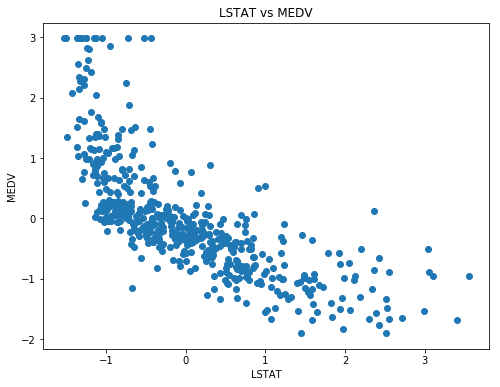

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(corr_df["LSTAT"], corr_df['MEDV'])
plt.title("LSTAT vs MEDV")
plt.xlabel("LSTAT")
plt.ylabel("MEDV")
plt.show()

負の相関であると言える。

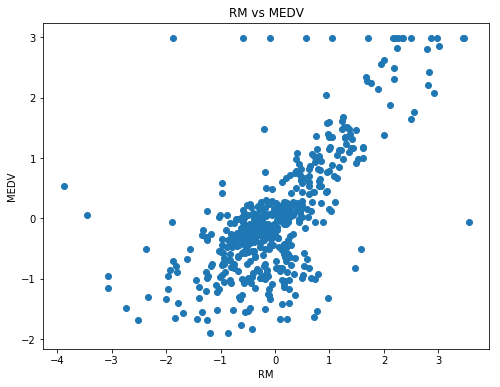

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(corr_df["RM"], corr_df['MEDV'])
plt.title("RM vs MEDV")
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.show()

外れ値がいくつかみられるものの、正の相関であると言える。

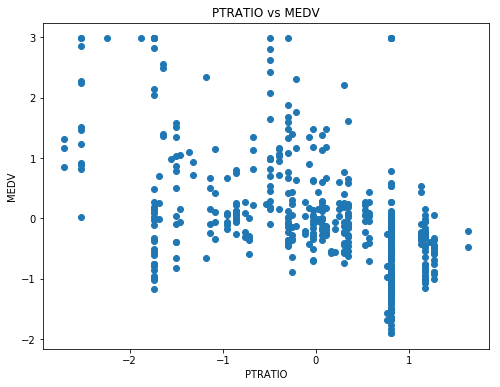

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(corr_df["PTRATIO"], corr_df['MEDV'])
plt.title("PTRATIO vs MEDV")
plt.xlabel("PTRATIO")
plt.ylabel("MEDV")
plt.grid(color='gray', alpha=0.2)
plt.show()

相関があるとは言えない。

## 3. 学習

決定木（回帰木）を使用して、max_depth = 4 で学習  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [13]:
# データセット分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
# 学習
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(
    max_depth=4, 
    random_state=1
)
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

- criterion：分割基準。gini（不純度）とentropy（情報利得）  
- max_depth：ツリーの深さの最大  
- min_samples_split：ノードに残る最小サンプル数。未満になれば分岐終了  
- min_samples_leaf：リーフに残るサンプル数の最低数  
- max_leaf_nodes：リーフの最大数  
- min_impurity_split：criterionが指定した値以下になれば分岐終了

In [15]:
# テストデータの予測値
tree.predict(X_test)

array([31.36034483, 31.36034483, 18.77878788, 23.74588235, 17.85909091,
       20.52613636, 23.74588235, 20.52613636, 18.77878788, 23.74588235,
       31.36034483, 31.36034483, 20.52613636, 20.26666667, 20.52613636,
       17.85909091,  9.14285714, 42.06666667, 23.74588235, 14.55106383,
       20.52613636, 14.55106383, 23.74588235, 23.74588235, 23.74588235,
        9.14285714, 14.06666667, 20.52613636, 47.875     , 14.55106383,
       23.74588235, 18.77878788, 47.875     , 14.55106383, 23.74588235,
       20.52613636, 14.55106383, 31.36034483,  9.14285714, 20.52613636,
       23.74588235, 23.74588235, 23.74588235, 18.77878788, 14.55106383,
        9.14285714, 47.875     ,  9.14285714, 20.52613636, 20.52613636,
       20.52613636, 20.52613636, 23.74588235, 17.85909091, 14.55106383,
       23.74588235, 14.55106383, 23.74588235, 20.52613636, 42.06666667,
       17.85909091, 23.74588235, 14.55106383, 18.77878788, 18.77878788,
       31.36034483, 42.06666667, 23.74588235, 20.52613636, 20.52

In [16]:
# テストデータの決定係数
tree.score(X_test,y_test)

0.8550749966837611

### 決定係数について
決定係数 $R^2$ とは、回帰モデルによって実データをどれくらい説明できているか（** 回帰分析の精度 **）を表す指標。

$R^2=1-\dfrac{\displaystyle\sum_{i=1}^n(y_i-f(x_i))^2}{\displaystyle\sum_{i=1}^n(y_i-\mu_Y)^2}$

$(x_i,y_i)$：データ　$\mu_Y$：$y_i$の平均　$f(x)$：回帰モデル

- 分母は全変動と呼ばれ、データそもそものばらつき具合を表す。
- 分子は残差変動と呼ばれ、回帰モデルと実測値とのズレを表す。
- 決定係数が 1 に近い → 残差変動が（全変動に比べて）小さい → よい回帰モデルである と言える。


決定係数を正しく理解  
http://xica.net/magellan/marketing-idea/stats/about-coefficient-of-determination/

## 4. 決定木の視覚化

In [17]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    tree,
    #filled=True, 
    #rounded=True,
    class_names=None, # クラス一覧
    feature_names=boston.feature_names, # 説明変数一覧
    # .dotファイルのデータを直接dot_data変数に代入
    out_file=None
)
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

True

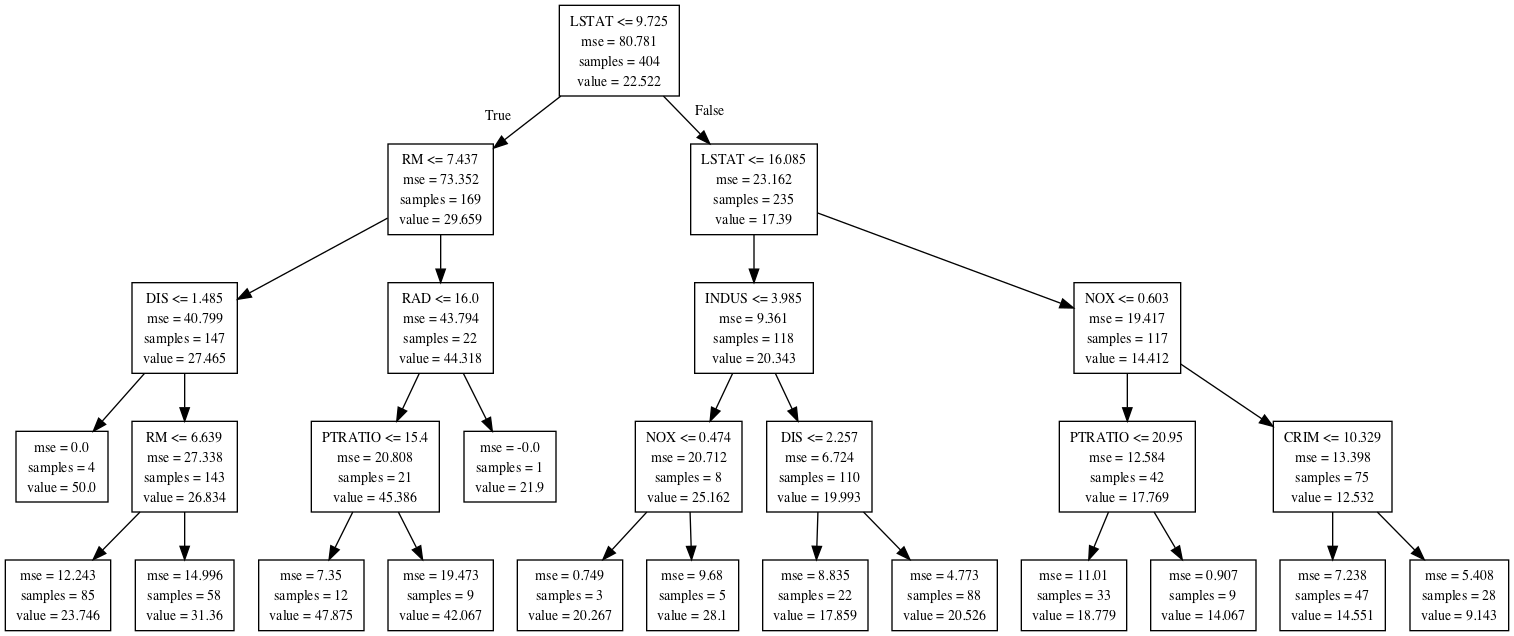

In [18]:
from IPython.display import Image, display_png
display_png(Image('tree.png'))

## 5. 特徴量の重要度

In [19]:
tree.feature_importances_

array([0.01773775, 0.        , 0.00688876, 0.        , 0.02949726,
       0.25694519, 0.        , 0.07649874, 0.01819707, 0.        ,
       0.01142332, 0.        , 0.58281193])

In [20]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [21]:
importance_df=pd.DataFrame(data=tree.feature_importances_, columns=["importance"], index=boston.feature_names)
importance_df=importance_df.sort_values('importance', ascending=False)
importance_df

,importance
LSTAT,0.582812
RM,0.256945
DIS,0.076499
NOX,0.029497
RAD,0.018197
CRIM,0.017738
PTRATIO,0.011423
INDUS,0.006889
ZN,0.000000
CHAS,0.000000


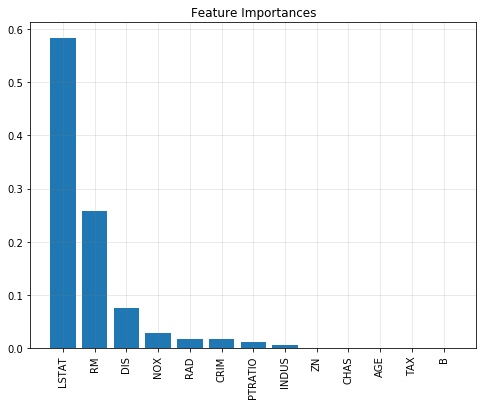

In [31]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances')
plt.bar(range(len(importance_df)),importance_df["importance"])
plt.xticks(range(len(importance_df)), importance_df.index, rotation=90)
plt.grid(color='gray', alpha=0.2)
plt.show()

MEDVに対する相関係数同様、**LSTAT, RM の重要度は高い **が、必ずしも** 相関係数に従うとは限らない **ことが分かる。  
** ZN, CHAS, AGE, TAX, B **に関しては、回帰に重要ではないとしている。

## 6. 最大深度について
各 max_depth ごとの決定係数を測定

In [23]:
# 測定する最大の深さ
MAX_DEPTH = 10
depths = range(1, MAX_DEPTH + 1)

In [24]:
from sklearn.tree import DecisionTreeRegressor

r2_scores = []
for depth in depths:
    tree = DecisionTreeRegressor(
        max_depth=depth, 
        random_state=1
    )
    tree.fit(X_train, y_train)
    score=tree.score(X_test,y_test)
    print('max depth={0}: {1}'.format(depth, score))
    r2_scores.append(score)

max depth=1: 0.4065506603539386
max depth=2: 0.7436066708330533
max depth=3: 0.6647121948539862
max depth=4: 0.8550749966837611
max depth=5: 0.7105741019604501
max depth=6: 0.8376046099809956
max depth=7: 0.8455731852187427
max depth=8: 0.8426084359323585
max depth=9: 0.8251696178434911
max depth=10: 0.8236160978472038


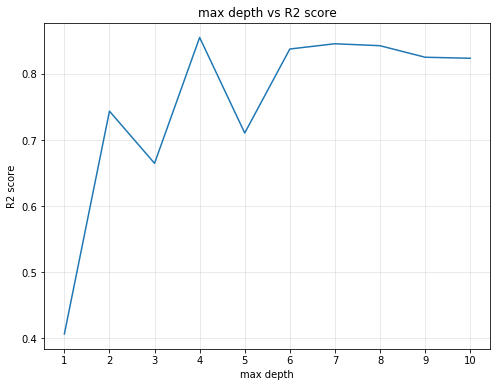

In [25]:
list_depths = list(depths)

plt.figure(figsize=(8,6))
plt.plot(list_depths, r2_scores)
plt.title('max depth vs R2 score')
plt.xlabel('max depth')
plt.ylabel('R2 score')
plt.xticks(list_depths)
plt.grid(color='gray', alpha=0.2)
plt.show()

最大深度 4 で決定係数の最高値を測定

## 7. 学習曲線
max_depth = 1〜10で学習された学習曲線の描画  
http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    plt.legend(loc="best")

Automatically created module for IPython interactive environment


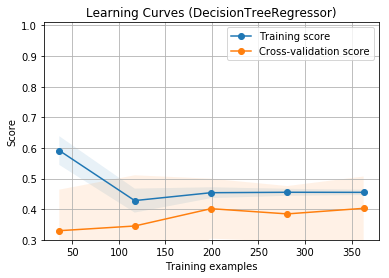

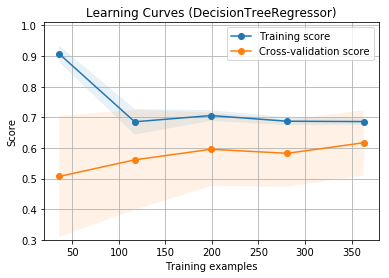

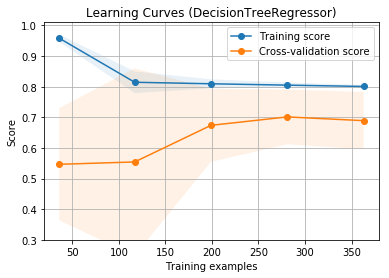

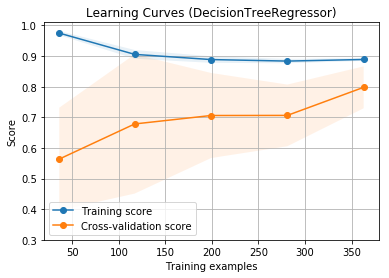

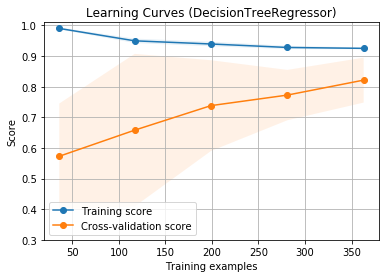

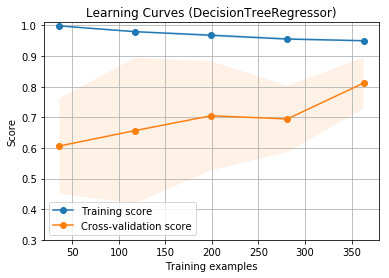

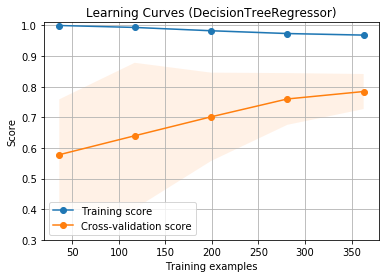

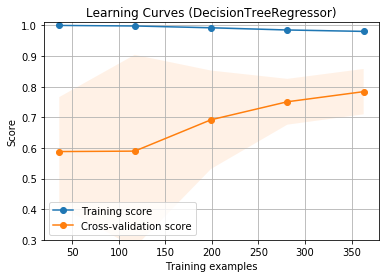

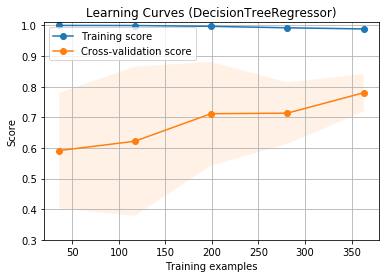

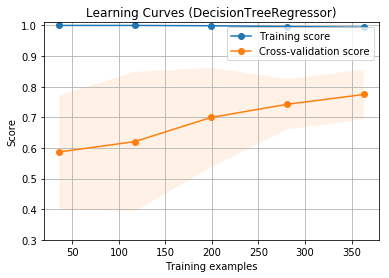

In [27]:
print(__doc__)

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

title = "Learning Curves (DecisionTreeRegressor)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

for degree in range(1,11):
    estimator = DecisionTreeRegressor(max_depth=degree)
    plot_learning_curve(estimator, title, X_train , y_train, ylim=(0.3, 1.01), cv=10, n_jobs=4)

### 学習曲線について
モデルが過学習（Overfitting）しているか、未学習（Underfitting）しているかを診断

- 未学習 → モデルが単純 → High Bias
- 過学習 → モデルが複雑 → High Variance

#### 未学習
- トレーニングデータ、クロスバリデーションデータともにスコアが低く、学習できていない状態。  
- 深さが浅いときは、モデルが単純で、どちらも値が小さく High Bias の状態であると言える。
- 未学習の対処法：特徴量追加、正則化の強さを下げる。

#### 過学習
- トレーニングデータのスコアがよく、クロスバリデーションデータのスコアが低く、偏った学習をしている状態。  
- 深さを深くしていくと、モデルは複雑になり、High Variance の状態であると言える。
- 過学習の対処法：データ追加、正則化の強さを上げる。

学習曲線を見ると** max_depth = 4 or 5 が適している **と判断。

## 8. ハイパーパラメーターチューニング
** グリッドサーチ **によるハイパーパラメーターチューニング

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': list(range(1, 11)),
}
tree = DecisionTreeRegressor(
    random_state=1
)
grid_search = GridSearchCV(
    tree,
    param_grid=params,
    cv=10
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
print("Best Params：", grid_search.best_params_)
print("Best Score：", grid_search.best_score_)

Best Params： {'max_depth': 5}
Best Score： 0.8147752417901831


### グリッドサーチについて
- あらかじめ**範囲（ ex. 0,1,2,3,4,5など ）**を指定  
- 実際にそのパラメータでモデルの精度を測定し、最適なパラメータを選出
- パラメータの値をしらみつぶしに探索するので、計算量が多い

### ランダムサーチについて
- あらかじめ**分布（ ex. 平均0, 標準偏差1の正規分布など ）**を指定  
- そこからランダムに取り出し、実際にそのパラメータでモデルの精度を測定し、最適なパラメータを選出
- パラメータの組み合わせをランダムで選んで比較を行うため計算量が少なく、取り急ぎ、適度なパラメータを見つけるのに適している

### neg_mean_squared_error について
sklearn では、accuracy に代表されるように** 高いスコアが優れたスコアであるといったレギュレーション **に従っている。  
なので loss関係の scoring は、negative（マイナス値）を返す。

In [30]:
print("決定係数：", grid_search.score(X_test, y_test))

決定係数： 0.7105741019604501
